In [296]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

In [297]:
n = 200

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1, axis=1)
w2 = np.cumsum(Zn2, axis=1)

In [298]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [299]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, H, c):
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [300]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1, T=1.5):

    cov = covariance_exp(eta=eta, lam=lam, T=T)
    L = np.linalg.cholesky(cov)
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1, T=1.5):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1, T=1.5):

    cov = covariance_frac(T=T, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [301]:
%%timeit
sample_XT_cumsum(lam=1, eta=1)

7.82 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [302]:
%%timeit
sample_XT_Cholesky(lam=1, eta=1)

6.07 ms ± 86.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [303]:
def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    T=1.5
    times = np.linspace(0, T, n + 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [304]:
def sample_B(rho=0.5, T=1.5):
    sample = rho*np.sqrt(T/n)*w1+np.sqrt(1-rho**2)*np.sqrt(T/n)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

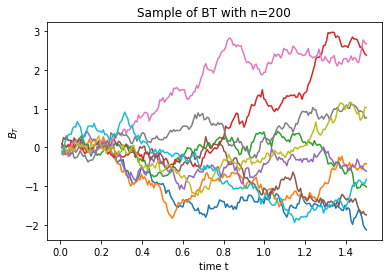

In [305]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [306]:
def Sigma(X, vars, ksi=0.5, a0=1, a1=1):
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

In [307]:
def sample_S_exp(rho=0.5, eta=1, lam=1, S0=100, ksi=0.5, a0=1, T=1.5):
    
    X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
    

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

def sample_S_frac(rho=0.5, H=0.5, c=1, S0=100, ksi=0.5, a0=1, T=1.5):
    
    X_sample, cov = sample_XT_frac(H=H, c=c, T=T)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

(10000, 201)


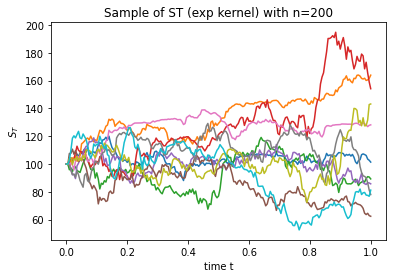

In [308]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=T)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}")
plt.show()


(10000, 201)


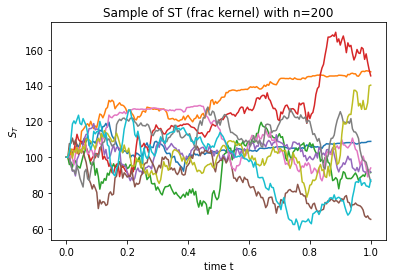

In [309]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_frac(rho=-0.8, T=T)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (frac kernel) with n={n}")
plt.show()

In [310]:
def call_exp(S0, K, T, rho=0.5, eta=1, lam=1):
    return np.mean(np.maximum(sample_S_exp(rho=rho, eta=eta, lam=lam, S0=S0, T=T)[:,-1]-K, 0))

In [311]:
def call_frac(S0, K, T, rho=0.5, H=0.5, c=1, ksi=0.5, a0=1):
    return float(np.mean(np.maximum(sample_S_frac(rho=rho, H=H, c=c, S0=S0, ksi=ksi, a0=a0, T=T)[:,-1]-K, 0)))

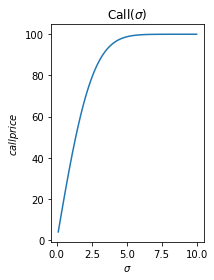

In [312]:
from scipy.stats import norm

# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf

def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call

black_scholes_call(S=100, K=100, T=T, r=0, sigma=0.5)

fig = plt.figure()
ax = fig.add_subplot(121)

sigmas = np.linspace(0.1,10,100)
sample = [black_scholes_call(S=100, K=100, T=T, r=0, sigma=sigma) for sigma in sigmas]
ax.plot(sigmas, sample, "-")

ax.set_xlabel("$\sigma$")
ax.set_ylabel("$call price$")
ax.set_title("Call($\sigma$)")


plt.show()

In [319]:
%%time
# Here we calibrate using scipy.optimize for one slice

from scipy.optimize import minimize

# x0 = [-0.75, 0.25, 1, 0.5, 1]
x0 = [-0.7, 0.25, 0.5, 1, 0.5]

bounds = ((-1,-0.5),(0,0.5),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))

C = call_frac(S0=120, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5)

def call_frac_optimize(x, S0=120, K=100, T=1.5):
    ''' Objective function '''
    return np.abs(call_frac(K=K, S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4]) - C)


res = minimize(call_frac_optimize, x0, method='SLSQP', bounds=bounds)
print(res)

/tmp/ipykernel_5713/1784926477.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
/tmp/ipykernel_5713/1906855154.py:2: RuntimeWarning: invalid value encountered in true_divide
  return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)


     fun: 2.025758760737517e-08
     jac: array([ -9.23272371,  13.70430708,  -0.37830639, -26.17344332,
         0.3534708 ])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-0.79829243,  0.30459887,  0.53944004,  1.01584297,  0.5773421 ])
CPU times: user 3min 41s, sys: 5.65 s, total: 3min 46s
Wall time: 41 s


In [322]:
%%time
# Here we calibrate using scipy.optimize for plural slices

from scipy.optimize import least_squares

def loss_frac(x, u, y):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
    '''
    return np.array([call_frac(K=u[i][0], S0=u[i][1], T=u[i][2], rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4]) - y[i] for i in range(len(y))])

x0 = np.array([-0.7, 0.25, 0.5, 1, 0.5])

bounds = ([-1, 0, -np.inf, -np.inf, -np.inf], [-0.5, 0.5, np.inf, np.inf, np.inf])

u = np.array([[100, 100, 1.5], [100, 120, 1], [100, 100, 1.2]])
y = np.array([call_frac(S0=u[i][0], K=u[i][1], T=u[i][2], rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(u))])

least_squares(loss_frac, x0, bounds=bounds, args=(u,y), verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6484e+02                                    7.91e+02    
       1              2         1.8487e+02      8.00e+01       1.83e+00       5.22e+02    
       2              3         1.5134e+02      3.35e+01       1.83e+00       6.06e+01    
       3              4         1.4663e+02      4.71e+00       3.67e+00       9.28e+01    
       4              5         1.4647e+02      1.61e-01       2.41e+00       5.43e+01    
       5              6         1.4552e+02      9.47e-01       5.14e-01       6.90e+01    
       6              9         1.4534e+02      1.82e-01       2.45e-02       1.79e+01    
       7             10         1.4505e+02      2.96e-01       6.72e-03       7.08e-01    
       8             11         1.4485e+02      1.99e-01       1.47e-02       1.26e+01    
       9             14         1.4484e+02      5.23e-03       3.13e-03       5.98e-01    

 active_mask: array([0, 0, 0, 0, 0])
        cost: 144.76165903304215
         fun: array([-6.73660119, 14.23074785, -6.45192515])
        grad: array([ 0.14608265,  0.42106183,  0.00065355, -0.053737  ,  0.02694557])
         jac: array([[ 1.60176158e+00,  9.02329731e+00, -1.41126939e-04,
         4.23958533e+01, -5.81765175e-03],
       [ 1.33791590e+00,  7.48242283e+00, -8.68044523e-05,
         3.76312933e+01, -3.57723236e-03],
       [ 1.25590920e+00,  7.01698399e+00, -1.45402105e-04,
         3.87436652e+01, -5.99217415e-03]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 46
        njev: 32
  optimality: 0.05373700220232536
      status: 2
     success: True
           x: array([-0.74251132,  0.00893056,  5.13068043,  0.6985702 , -0.12452387])